In [156]:
# Para mas información, consulta el GitHub [https://github.com/Zygmut/Practica_3_IA]
# Autores: Palmer Pérez, Rubén; Torres Torres, Marc; Orr, Kieran Donal

# Setup
Importamos todos los paquetes necesarios para la práctica. 

In [157]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.ensemble import RandomForestClassifier 

Creamos un conjunto de variables para facil acceso y cambio de parámetros

In [158]:
TEST_SIZE = 0.33             # Proportion for test size in relation to the dataset
CORRELATION_THRESHOLD = 0.05 # Threshold to remove columns in the correlation matrix
ALTERNATIVE_MODE = False    # Quality (0-10) or ("bad", "average", "good")
QUALITY_THRESHOLD = 6        # Threshold that defines a range for each quality of wine ("bad", "average", "good")

Definimos una variable `DEBUG` (y su método de uso) que, en caso de estar activada, nos dará información adicional a lo largo de la ejecución del proyecto 

In [159]:
DEBUG = True 

def debugPrint(string):
    if DEBUG : print(f"[🐛] {string}")

# El dataset
Cargamos los datasets y les añadimos la columna `type` que nos permitara reconocer de que tipo son una vez juntados los datasets. Si `type = 0` el vino será blanco, de lo contrario sera rojo.

In [160]:
white = pd.read_csv("dataset/winequality-white.csv", sep=';')
white.insert(0, 'type', 0)
red = pd.read_csv("dataset/winequality-red.csv", sep= ';')
red.insert(0, 'type', 1)
df = pd.concat([white, red])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6497 entries, 0 to 1598
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   int64  
 1   fixed acidity         6497 non-null   float64
 2   volatile acidity      6497 non-null   float64
 3   citric acid           6497 non-null   float64
 4   residual sugar        6497 non-null   float64
 5   chlorides             6497 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6497 non-null   float64
 10  sulphates             6497 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 710.6 KB


Preparamos los datos del dataset eliminando todos los posibles valores nulos y transformando los valores que no sean `np.float64` o `np.int64` 

In [161]:
# Preparacion del dataset

labelencoder = LabelEncoder()

if not df[df.isna().any(axis=1)].shape[0] == 0 :
    debugPrint("Valores nulos eliminados para el dataframe")
    
df.dropna(inplace=True) # Eliminacion de valores nullos

for column in df.columns: # Transformar posibles valores no numericos
    if not df[column].dtype in (np.float64, np.int64):
        df[column] = labelencoder.fit_transform(df[column])
        debugPrint(f"Los valores de {column} se han transformado a numericos")


## Visualización de datos
En este apartado visualizaremos los datos para un entendimiento gráfico de nuestras carácteres

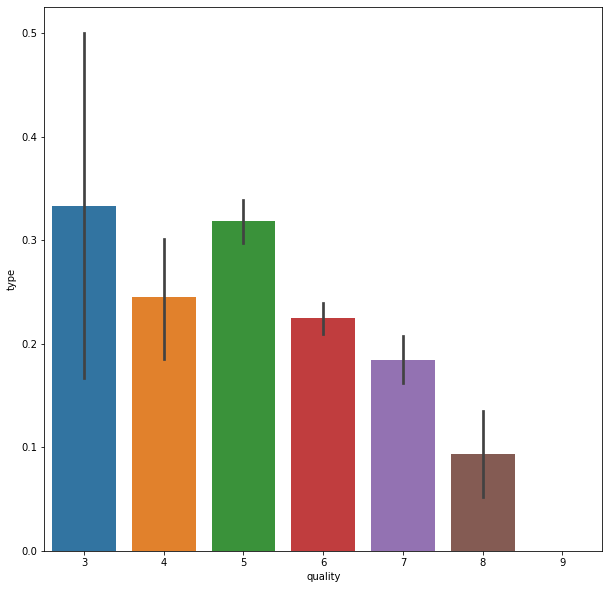

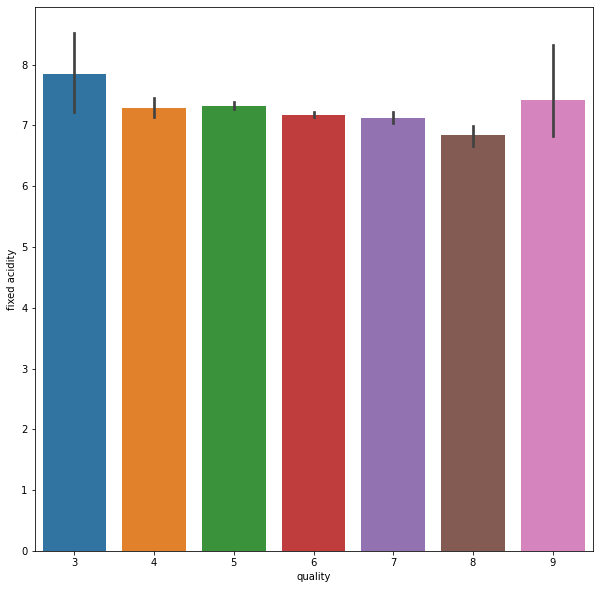

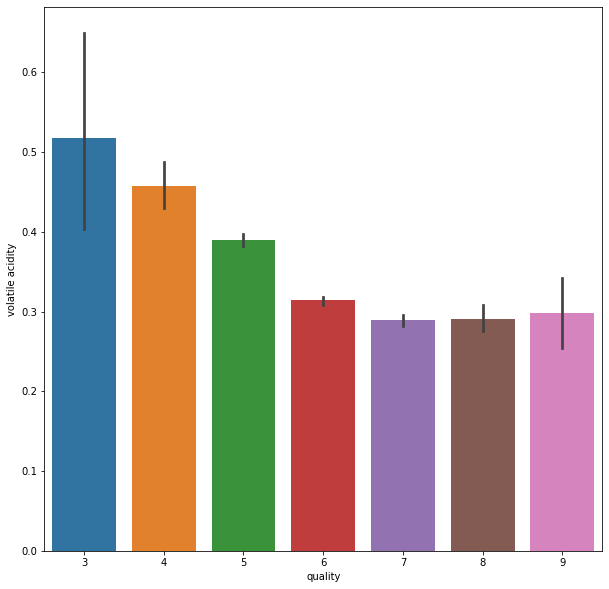

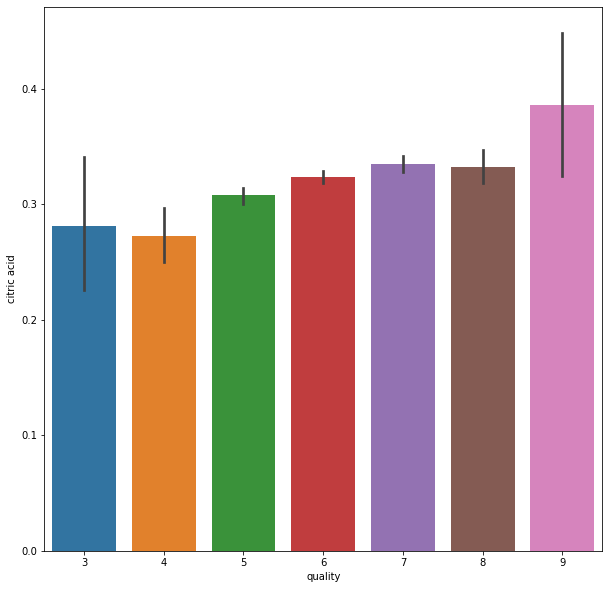

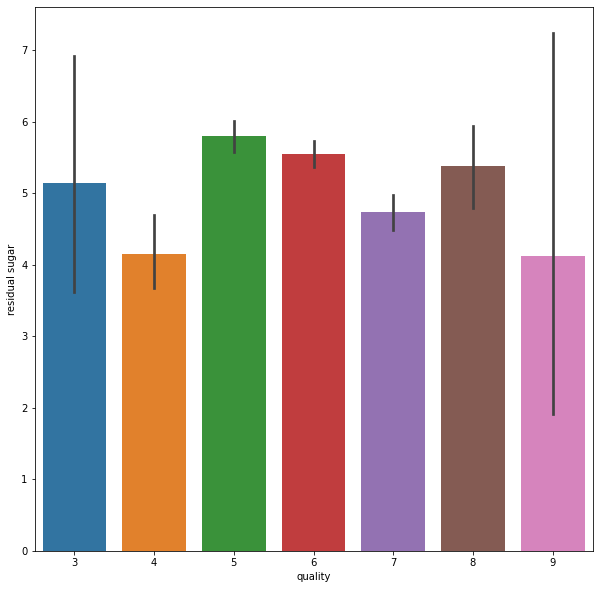

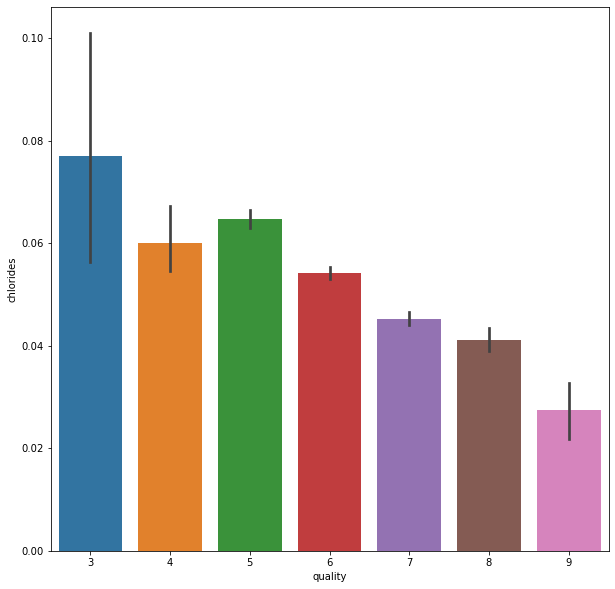

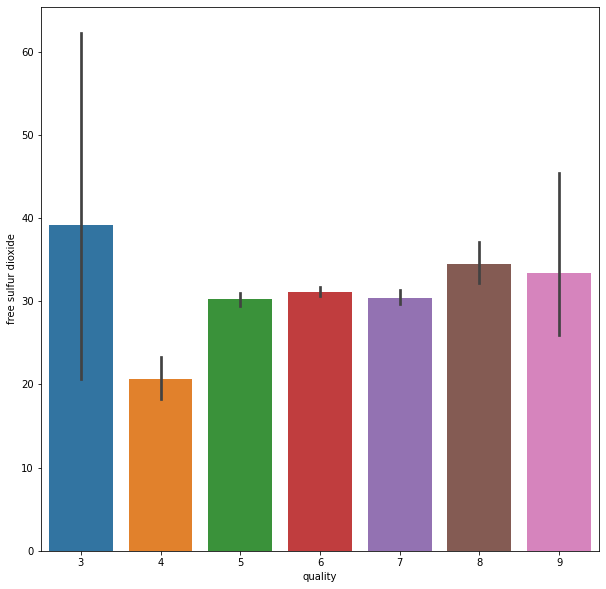

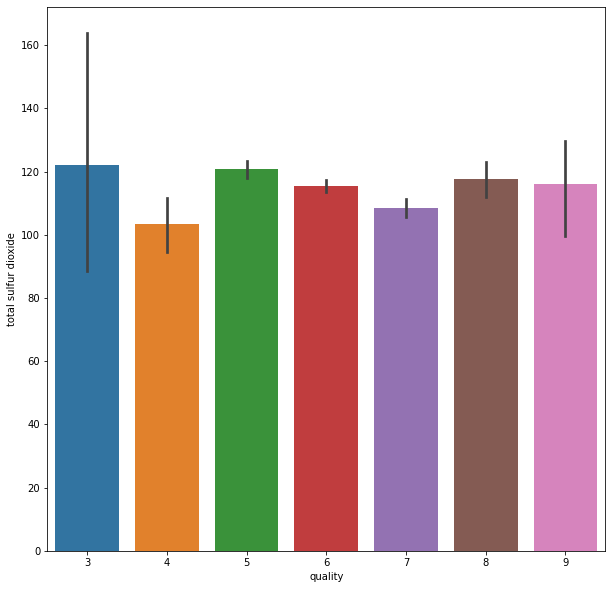

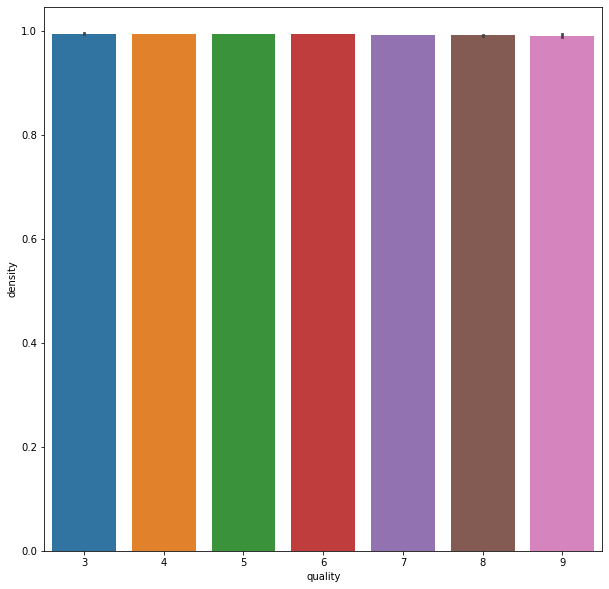

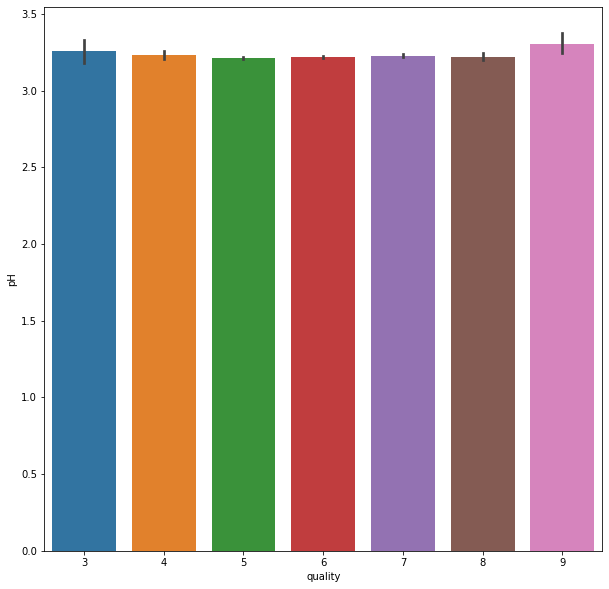

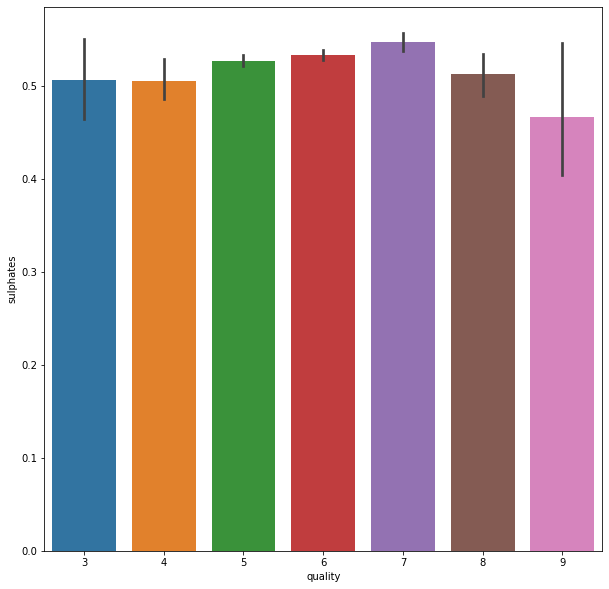

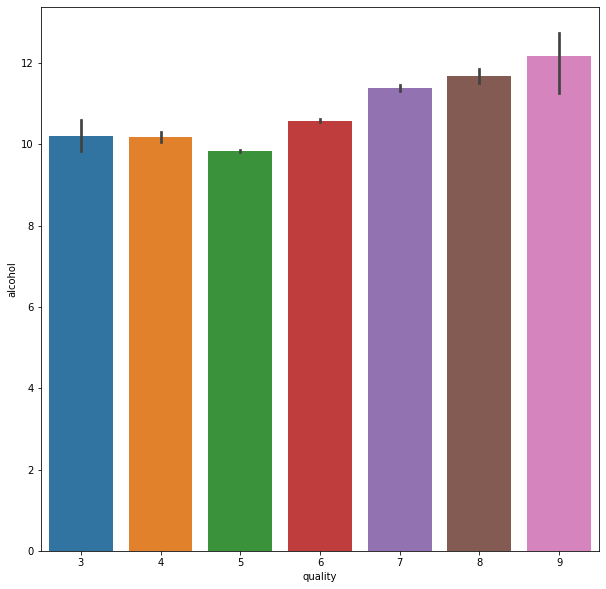

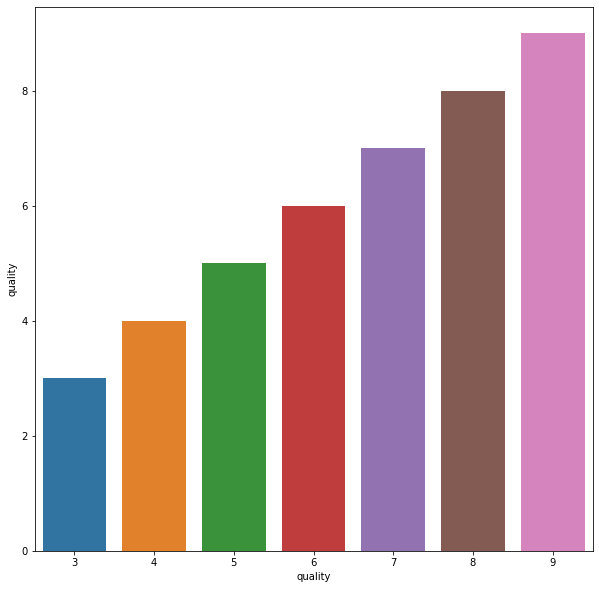

In [162]:
for i, col in enumerate(df.columns):
    plt.figure(i, figsize=(10,10))
    sns.barplot(x='quality', y=col, data=df)

## Matriz de correlación
Como ya hemos visto en la visualización de los datos tenemos caracteristicas que, respecto a calidad, no nos ofrecen mucha variación. Para asegurarnos de esta independecia entre caracteristicas, analizaremos la matriz de correlación. Tenemos una variable llamada `CORRELATION_THRESHOLD` que define la desviación mínima que aceptamos. Es decir, si tenemos una correlación de `0.03` con respecto a _quality_, podemos decir que son suficientemente independientes como para no tenerlas en cuenta. De esta manera, podemos reducir el tamaños de las caracteristicas para el entrenamiento de nuestro modelos

[🐛] Removed column 4
[🐛] Removed column 7
[🐛] Removed column 9
[🐛] Removed column 10


<AxesSubplot:>

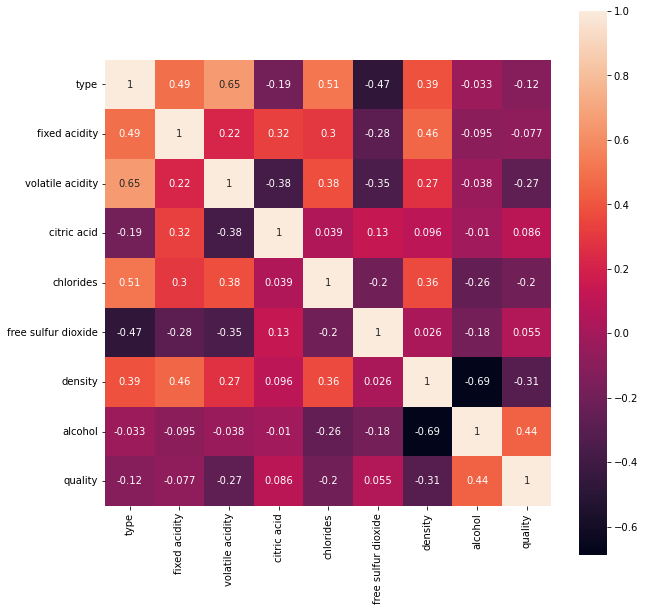

In [163]:
fig = plt.figure(figsize=(10,10))

removed_columns = []

for i in range(len(df.corr()["quality"])):
    if abs(df.corr()["quality"][i]) < CORRELATION_THRESHOLD:
        debugPrint(f"Removed column {i}") 
        removed_columns.append(i)
        

df.drop(df.columns[removed_columns], axis=1, inplace = True)
  
sns.heatmap(df.corr(), annot=True, square=True)


Adicionalmente, definiremos unos rangos de calidad de tal manera que :
- baja &rarr; "quality" < `QUALITY_THRESHOLD` 
- media &rarr; "quality" = `QUALITY_THRESHOLD` 
- alta &rarr; "quality" > `QUALITY_THRESHOLD` 

Lo tomaremos tal que:
- baja &rarr; 1 
- media &rarr; 2
- alta &rarr; 3

In [164]:
if ALTERNATIVE_MODE :
    debugPrint("Alternative mode detected")
    df["quality"] = df["quality"].apply(lambda y: 1 if y<QUALITY_THRESHOLD else y)
    df["quality"] = df["quality"].apply(lambda y: 2 if y==QUALITY_THRESHOLD else y)
    df["quality"] = df["quality"].apply(lambda y: 3 if y>QUALITY_THRESHOLD else y)

debugPrint(df["quality"].unique())

[🐛] [6 5 7 8 4 3 9]


## Escalado de datos
Por último, escalamos los datos y separamos las "features" y etiquetas

In [165]:
m_M_scaler = preprocessing.MinMaxScaler()

# Separamos las features de las etiquetas 
y = df["quality"]
df.drop("quality", axis=1, inplace=True)
x = df.values

# Escalamos los datos 
x = m_M_scaler.fit_transform(x)


[6 5 7 8 4 3 9]


### Separación del conjunto de entrenamiento, validación y testeo
Una vez obtenido nuestro dataset con sus valores procesados, creamos los 2 subconjuntos de datos que nos permitirán entrenar nuestros modelos (entrenamiento y testeo). El subconjutno de validación se creará posteriormente.

In [171]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=TEST_SIZE, random_state=42)

AttributeError: 'numpy.ndarray' object has no attribute 'unique'

# Modelos
Una vez preparado nuestros datasets de entrenamiento y testeo, podemos usarlos para nuestros modelos de machine learning

In [142]:
# Definimos las etiquetas
targetQuality = [str(i) for i in y.unique()] 
debugPrint(targetQuality)
targetType = ["bad", "average", "good"]

[🐛] ['6', '5', '7', '8', '4', '3', '9']


## Aplicación

### Regresión lineal

In [174]:
clr = LogisticRegression(random_state=0).fit(x_train, y_train)
y_hat = clr.predict(x_test)
print(classification_report(y_test, y_hat, target_names= (targetType if ALTERNATIVE_MODE else targetQuality)))

              precision    recall  f1-score   support

           6       0.00      0.00      0.00         7
           5       1.00      0.01      0.03        71
           7       0.58      0.61      0.60       707
           8       0.51      0.72      0.60       939
           4       0.51      0.11      0.18       364
           3       0.00      0.00      0.00        57

    accuracy                           0.54      2145
   macro avg       0.43      0.24      0.24      2145
weighted avg       0.54      0.54      0.49      2145



D:\Users\ruben\anaconda3\envs\ml-enviroment\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Users\ruben\anaconda3\envs\ml-enviroment\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Users\ruben\anaconda3\envs\ml-enviroment\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precis

### Perceptron

In [ ]:
cp = Perceptron(random_state=0).fit(x_train, y_train)
y_hat = cp.predict(x_test)
print(classification_report(y_test, y_hat, target_names=(targetType if ALTERNATIVE_MODE else targetQuality)))

              precision    recall  f1-score   support

         bad       0.38      1.00      0.54       785
     average       1.00      0.00      0.00       939
        good       0.56      0.08      0.14       421

    accuracy                           0.38      2145
   macro avg       0.64      0.36      0.23      2145
weighted avg       0.68      0.38      0.23      2145



### Random forest

In [ ]:
crf = RandomForestClassifier(random_state=0).fit(x_train, y_train)
y_hat = cp.predict(x_test)
print(classification_report(y_test, y_hat, target_names=(targetType if ALTERNATIVE_MODE else targetQuality)))

              precision    recall  f1-score   support

         bad       0.38      1.00      0.54       785
     average       1.00      0.00      0.00       939
        good       0.56      0.08      0.14       421

    accuracy                           0.38      2145
   macro avg       0.64      0.36      0.23      2145
weighted avg       0.68      0.38      0.23      2145

